In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define Prometheus API URL and query
PROMETHEUS_API_URL = "http://10.105.116.175:9090/api/v1/query_range"
PROMETHEUS_QUERY_throughput = ["rate(istio_requests_total{namespace='social-network'}[1m])",
                               "rate(istio_requests_total{namespace='social-network2'}[1m])",
                               "rate(istio_requests_total{namespace='social-network3'}[1m])"]
PROMETHEUS_QUERY_latency_avg = [ "rate(istio_request_duration_milliseconds_sum{namespace='social-network'}[1m])/ rate(istio_requests_total{namespace='social-network'}[1m])",
                                 "rate(istio_request_duration_milliseconds_sum{namespace='social-network2'}[1m])/ rate(istio_requests_total{namespace='social-network2'}[1m])",
                                  "rate(istio_request_duration_milliseconds_sum{namespace='social-network3'}[1m])/ rate(istio_requests_total{namespace='social-network3'}[1m])"]

# PROMETHEUS_QUERY_latency_p95 = "histogram_quantile(0.95, sum(rate(istio_request_duration_milliseconds_bucket{namespace='social-network'}[1m])) by (le))"
# Function to query Prometheus API
def query_prometheus(prometheus_url, query, start, end, step):
    params = {
        'query': query,
        'start': start.timestamp(),
        'end': end.timestamp(),
        'step': step
    }
    response = requests.get(prometheus_url, params=params)
    response.raise_for_status()
    return response.json()

# Function to parse Prometheus response
def parse_prometheus_data(data, check_start_time=None, check_end_time=None):
    results = data['data']['result']
    data_list = []
    for result in results:
        metric = result['metric']
        if 'values' in result:
            for value in result['values']:
                timestamp = datetime.utcfromtimestamp(value[0])
                metric_value = float(value[1])

                if (check_start_time is None or timestamp >= check_start_time) and \
                   (check_end_time is None or timestamp <= check_end_time):
                    data_list.append({
                        "metric": metric,
                        "timestamp": timestamp,
                        "value": metric_value
                    })
        else:
            print(f"No 'values' key found in result: {result}")
    return pd.DataFrame(data_list)



In [6]:
'''(1) query data for namesapce of social-network ''' # default k8s scheduling method

# Define the time range for filtering
from tabnanny import check

check_start_time = datetime(2024, 7, 14, 14, 38, 0) # UTC time
check_end_time = datetime(2024, 7, 14, 14, 58, 0)
step = "10s"  # Resolution

# Fetch data from Prometheus
data_throughput_1 = query_prometheus(PROMETHEUS_API_URL, PROMETHEUS_QUERY_throughput[0], check_start_time, check_end_time, step)
data_latency_avg_1 = query_prometheus(PROMETHEUS_API_URL, PROMETHEUS_QUERY_latency_avg[0], check_start_time, check_end_time, step)
# Debugging: Print the raw data to understand its structure
# print(data)

# Parse the data into a DataFrame with time filtering
df_throguput1 = parse_prometheus_data(data_throughput_1, check_start_time, check_end_time)
df_latency_avg1 = parse_prometheus_data(data_latency_avg_1, check_start_time, check_end_time)

# Save the DataFrame to a CSV file (if saved, comment this line)
df_throguput1.to_csv('data/prometheus_data_througuput1.csv', index=False)
df_latency_avg1.to_csv('data/prometheus_data_latency_avg1.csv', index=False) # save the data to csv file

print("Data has been saved to CSV file")

Data has been saved to CSV file


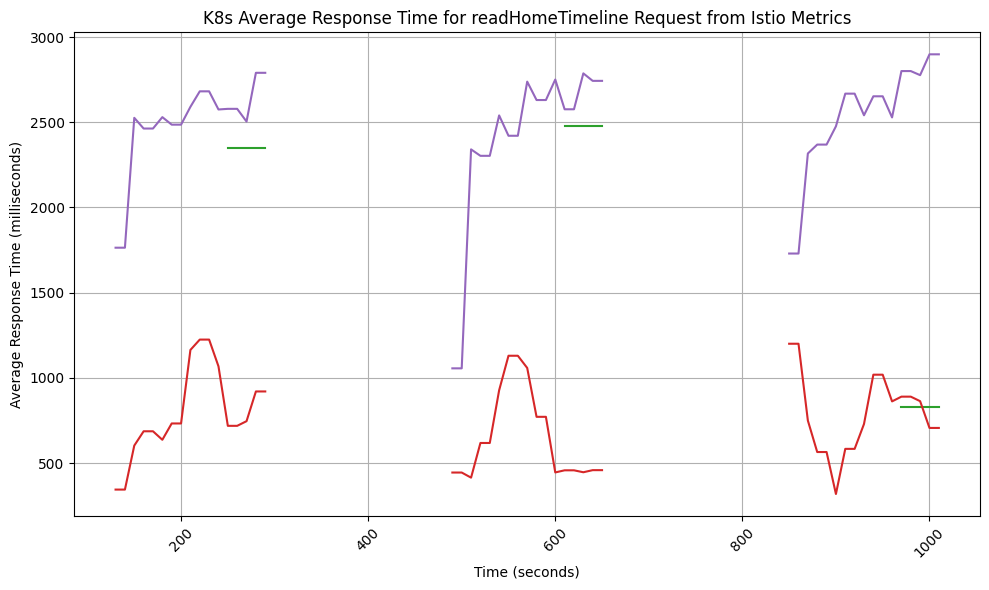

In [7]:
'''(1) plot Response Time for namesapce of social-network ''' # default k8s scheduling method
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'data/prometheus_data_latency_avg1.csv'
df = pd.read_csv(file_path)

# Convert the 'metric' column dictionaries to strings
df['metric'] = df['metric'].apply(lambda x: str(eval(x)))
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Calculate the elapsed time in seconds from the start of data collection
df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
# Plot the data
if not df.empty:
    plt.figure(figsize=(10, 6))
    
    for key, grp in df.groupby(['metric']):
        plt.plot(grp['elapsed_time'], grp['value'], label=key)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Average Response Time (milliseconds)')
    plt.title('K8s Average Response Time for readHomeTimeline Request from Istio Metrics')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.savefig('prometheus_data_plot.png')  # Save plot as a PNG file
    plt.show()  # Display the plot

# print("Plot has been saved to prometheus_data_plot.png")

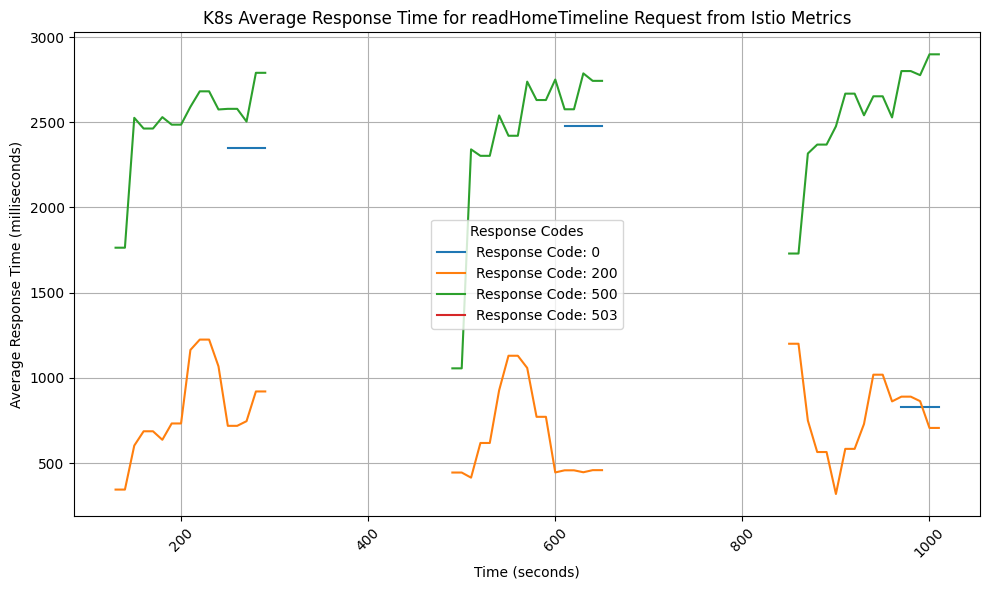

In [1]:
'''(1) plot Response Time for namesapce of social-network ''' # default k8s scheduling method

import pandas as pd
import matplotlib.pyplot as plt
import ast

# Load the CSV file
file_path = 'data/prometheus_data_latency_avg1.csv'
df = pd.read_csv(file_path)

# Convert the 'metric' column dictionaries to strings
df['metric'] = df['metric'].apply(lambda x: ast.literal_eval(x))
# Extract the response_code from the 'metric' column
df['response_code'] = df['metric'].apply(lambda x: x.get('response_code', 'unknown'))
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate the elapsed time in seconds from the start of data collection
df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

# Plot the data
if not df.empty:
    plt.figure(figsize=(10, 6))
    
    for key, grp in df.groupby('response_code'):
        plt.plot(grp['elapsed_time'], grp['value'], label=f'Response Code: {key}')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Average Response Time (milliseconds)')
    plt.title('K8s Average Response Time for readHomeTimeline Request from Istio Metrics')
    plt.grid(True)
    plt.legend(title='Response Codes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


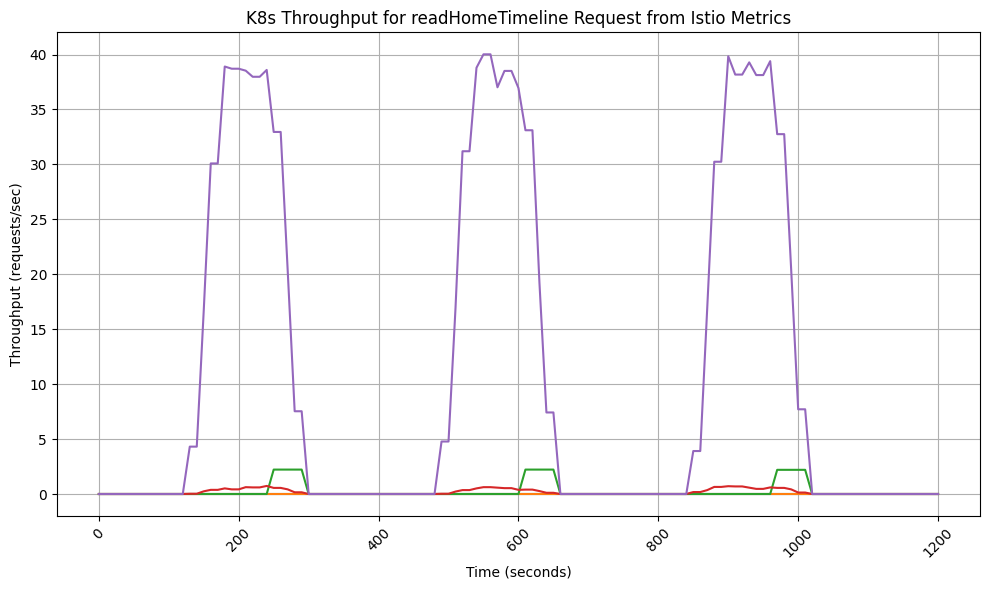

In [8]:

'''(1) plot Throughput for namesapce of social-network ''' # default k8s scheduling method
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'data/prometheus_data_througuput1.csv'
df = pd.read_csv(file_path)

# Convert the 'metric' column dictionaries to strings
df['metric'] = df['metric'].apply(lambda x: str(eval(x)))

# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate the elapsed time in seconds from the start of data collection
df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

# Plot the data
if not df.empty:
    plt.figure(figsize=(10, 6))
    
    for key, grp in df.groupby(['metric']):
        plt.plot(grp['elapsed_time'], grp['value'], label=key)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Throughput (requests/sec)')
    plt.title('K8s Throughput for readHomeTimeline Request from Istio Metrics')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.savefig('prometheus_data_plot.png')  # Save plot as a PNG file
    plt.show()  # Display the plot

# print("Plot has been saved to prometheus_data_plot.png")

In [9]:
'''(2) query data for namesapce of social-network2 ''' # NetMARKS scheduling method

# Define the time range for filtering
from tabnanny import check


move_back_minutes = 60*19 +47  # Adjust based on actual query
# check_start_time = datetime.now() - timedelta(minutes=move_back_minutes + 60)  # 20 minutes ago
check_start_time = datetime(2024, 7, 14, 14, 40, 0) # UTC time
check_end_time = datetime(2024, 7, 14, 15, 00, 0)
step = "10s"  # Resolution

# Fetch data from Prometheus
data_throughput_1 = query_prometheus(PROMETHEUS_API_URL, PROMETHEUS_QUERY_throughput[1], check_start_time, check_end_time, step)
data_latency_avg_1 = query_prometheus(PROMETHEUS_API_URL, PROMETHEUS_QUERY_latency_avg[1], check_start_time, check_end_time, step)
# Debugging: Print the raw data to understand its structure
# print(data)

# Parse the data into a DataFrame with time filtering
df_throguput1 = parse_prometheus_data(data_throughput_1, check_start_time, check_end_time)
df_latency_avg1 = parse_prometheus_data(data_latency_avg_1, check_start_time, check_end_time)

# Save the DataFrame to a CSV file (if saved, comment this line)
df_throguput1.to_csv('data/prometheus_data_througuput2.csv', index=False)
df_latency_avg1.to_csv('data/prometheus_data_latency_avg2.csv', index=False) # save the data to csv file

print("Data has been saved to CSV file")

Data has been saved to CSV file


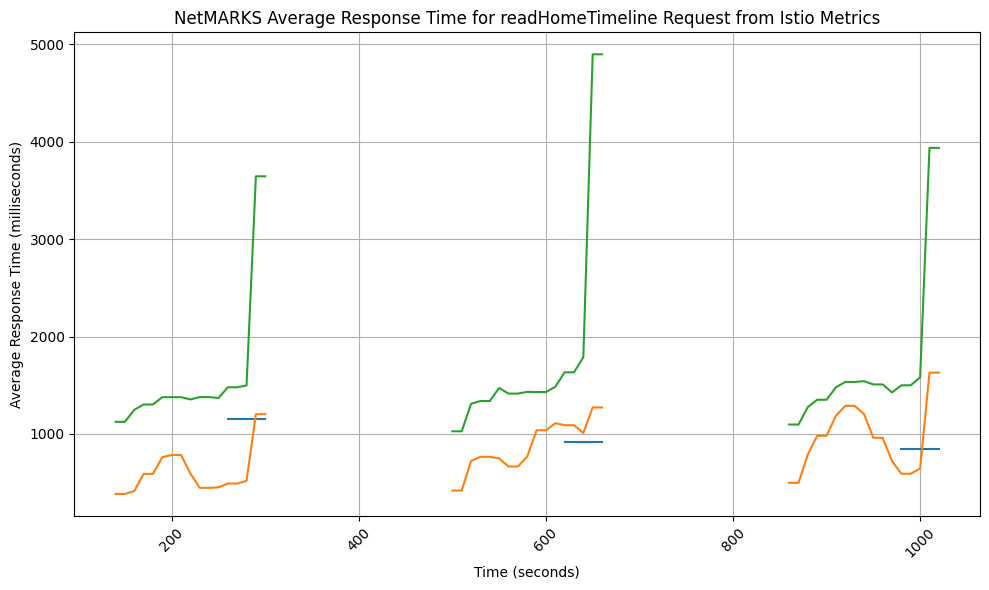

In [10]:
'''(2) plot Response Time for namesapce of social-network2 ''' #NetMARKS scheduling method
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'data/prometheus_data_latency_avg2.csv'
df = pd.read_csv(file_path)

# Convert the 'metric' column dictionaries to strings
df['metric'] = df['metric'].apply(lambda x: str(eval(x)))
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Calculate the elapsed time in seconds from the start of data collection
df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
# Plot the data
if not df.empty:
    plt.figure(figsize=(10, 6))
    
    for key, grp in df.groupby(['metric']):
        plt.plot(grp['elapsed_time'], grp['value'], label=key)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Average Response Time (milliseconds)')
    plt.title('NetMARKS Average Response Time for readHomeTimeline Request from Istio Metrics')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.savefig('prometheus_data_plot.png')  # Save plot as a PNG file
    plt.show()  # Display the plot

# print("Plot has been saved to prometheus_data_plot.png")

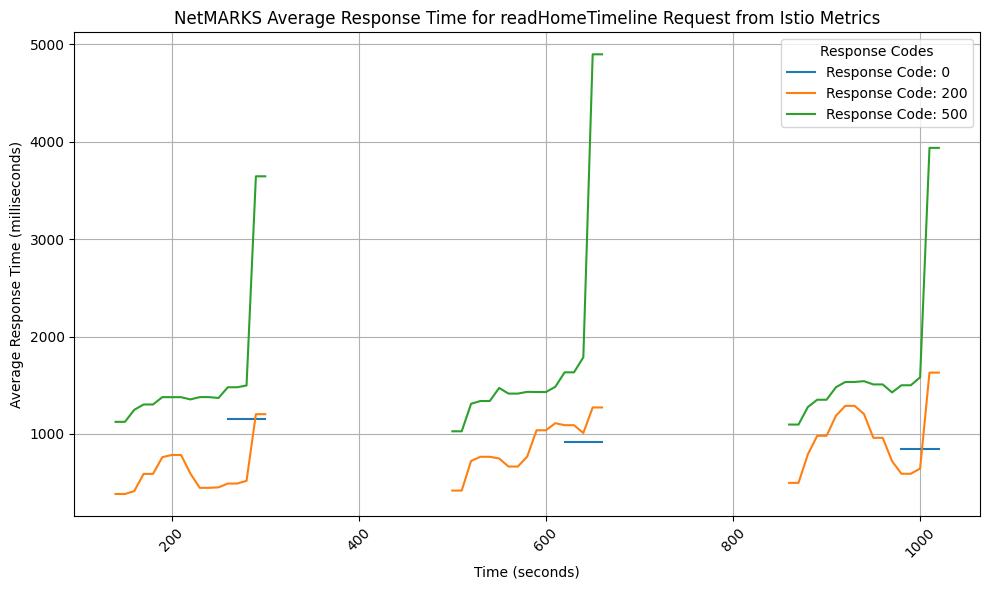

In [5]:
'''(1) plot Response Time for namesapce of social-network2 ''' # NetMARKS scheduling method

import pandas as pd
import matplotlib.pyplot as plt
import ast

# Load the CSV file
file_path = 'data/prometheus_data_latency_avg2.csv'
df = pd.read_csv(file_path)

# Convert the 'metric' column dictionaries to strings
df['metric'] = df['metric'].apply(lambda x: ast.literal_eval(x))
# Extract the response_code from the 'metric' column
df['response_code'] = df['metric'].apply(lambda x: x.get('response_code', 'unknown'))
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate the elapsed time in seconds from the start of data collection
df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

# Plot the data
if not df.empty:
    plt.figure(figsize=(10, 6))
    
    for key, grp in df.groupby('response_code'):
        plt.plot(grp['elapsed_time'], grp['value'], label=f'Response Code: {key}')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Average Response Time (milliseconds)')
    plt.title('NetMARKS Average Response Time for readHomeTimeline Request from Istio Metrics')
    plt.grid(True)
    plt.legend(title='Response Codes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


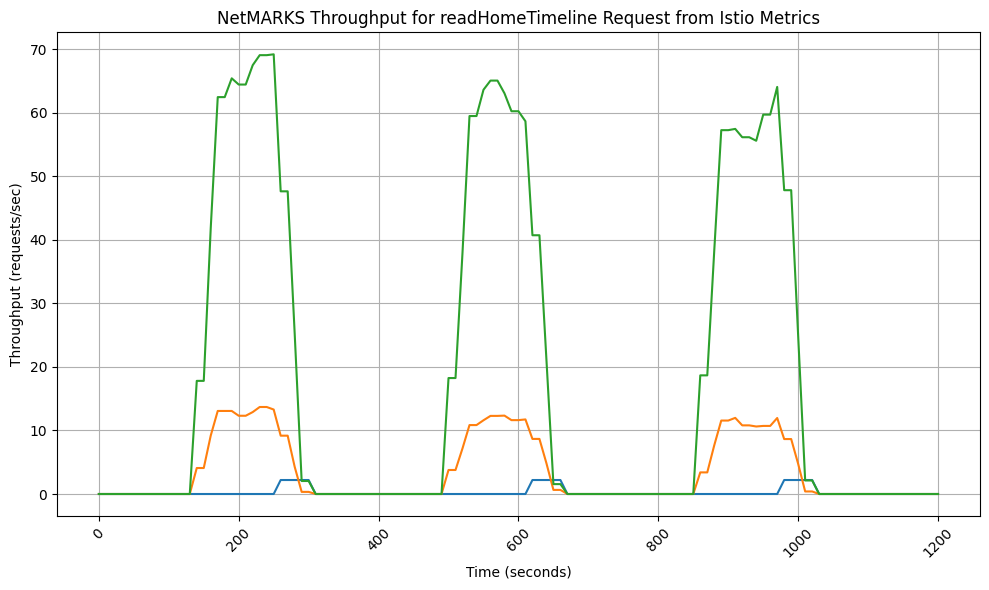

In [6]:
'''(2) plot Throughput for namesapce of social-network ''' # NetMARKS scheduling method
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'data/prometheus_data_througuput2.csv'
df = pd.read_csv(file_path)

# Convert the 'metric' column dictionaries to strings
df['metric'] = df['metric'].apply(lambda x: str(eval(x)))
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Calculate the elapsed time in seconds from the start of data collection
df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

# Plot the data
if not df.empty:
    plt.figure(figsize=(10, 6))
    
    for key, grp in df.groupby(['metric']):
        plt.plot(grp['elapsed_time'], grp['value'], label=key)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Throughput (requests/sec)')
    plt.title('NetMARKS Throughput for readHomeTimeline Request from Istio Metrics')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.savefig('prometheus_data_plot.png')  # Save plot as a PNG file
    plt.show()  # Display the plot

# print("Plot has been saved to prometheus_data_plot.png")

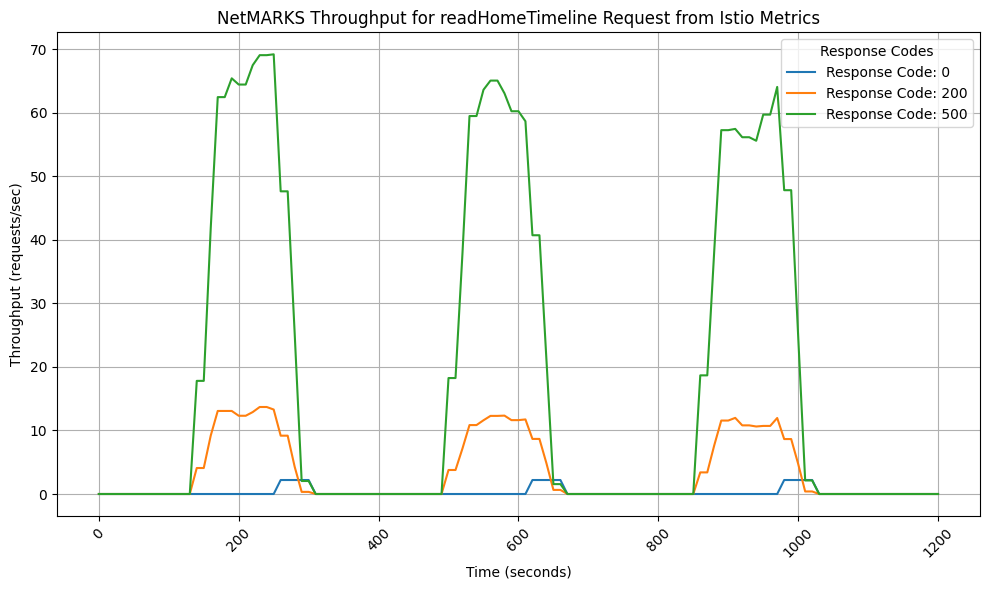

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# Load the CSV file
file_path = 'data/prometheus_data_througuput2.csv'
df = pd.read_csv(file_path)

# Convert the 'metric' column dictionaries to actual dictionaries
df['metric'] = df['metric'].apply(lambda x: ast.literal_eval(x))

# Extract the response_code from the 'metric' column
df['response_code'] = df['metric'].apply(lambda x: x.get('response_code', 'unknown'))

# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate the elapsed time in seconds from the start of data collection
df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

# Plot the data
if not df.empty:
    plt.figure(figsize=(10, 6))
    
    for key, grp in df.groupby('response_code'):
        plt.plot(grp['elapsed_time'], grp['value'], label=f'Response Code: {key}')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Throughput (requests/sec)')
    plt.title('NetMARKS Throughput for readHomeTimeline Request from Istio Metrics')
    plt.grid(True)
    plt.legend(title='Response Codes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [18]:
'''(3) query data for namesapce of social-network3 ''' # TraDE scheduling method

# Define the time range for filtering
from tabnanny import check
check_start_time = datetime(2024, 7, 14, 14, 40, 0) # UTC time
check_end_time = datetime(2024, 7, 14, 15, 2, 0)
step = "10s"  # Resolution

# Fetch data from Prometheus
data_throughput_1 = query_prometheus(PROMETHEUS_API_URL, PROMETHEUS_QUERY_throughput[2], check_start_time, check_end_time, step)
data_latency_avg_1 = query_prometheus(PROMETHEUS_API_URL, PROMETHEUS_QUERY_latency_avg[2], check_start_time, check_end_time, step)


# Parse the data into a DataFrame with time filtering
df_throguput1 = parse_prometheus_data(data_throughput_1, check_start_time, check_end_time)
df_latency_avg1 = parse_prometheus_data(data_latency_avg_1, check_start_time, check_end_time)

# Save the DataFrame to a CSV file (if saved, comment this line)
df_throguput1.to_csv('data/prometheus_data_througuput3.csv', index=False)
df_latency_avg1.to_csv('data/prometheus_data_latency_avg3.csv', index=False) # save the data to csv file

print("Data has been saved to CSV file")

Data has been saved to CSV file


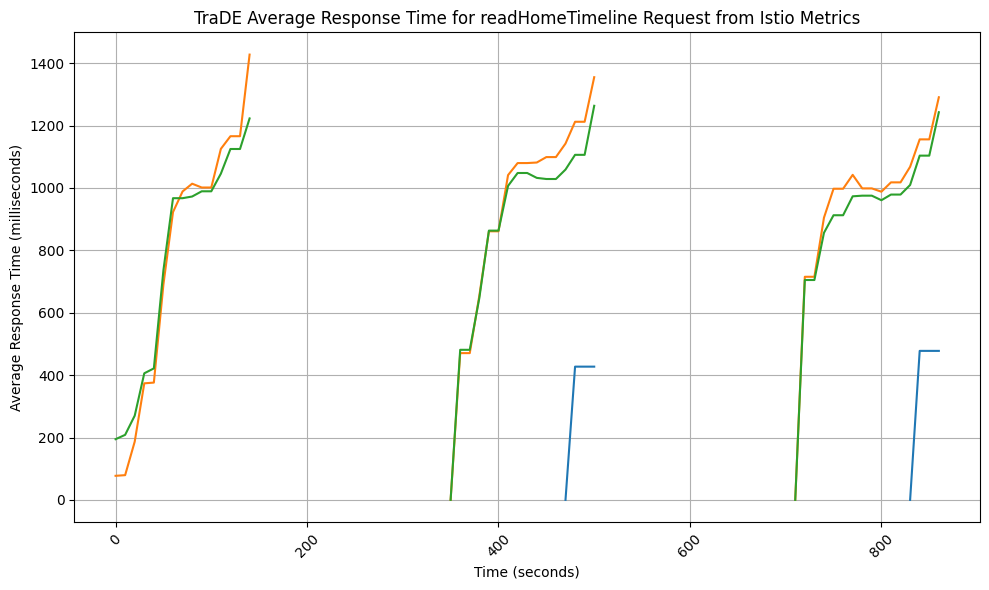

In [19]:
'''(3) plot Response Time for namesapce of social-network2 ''' # TraDE scheduling method
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'data/prometheus_data_latency_avg3.csv'
df = pd.read_csv(file_path)

# Convert the 'metric' column dictionaries to strings
df['metric'] = df['metric'].apply(lambda x: str(eval(x)))
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Calculate the elapsed time in seconds from the start of data collection
df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
# Plot the data
if not df.empty:
    plt.figure(figsize=(10, 6))
    
    for key, grp in df.groupby(['metric']):
        plt.plot(grp['elapsed_time'], grp['value'], label=key)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Average Response Time (milliseconds)')
    plt.title('TraDE Average Response Time for readHomeTimeline Request from Istio Metrics')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.savefig('prometheus_data_plot.png')  # Save plot as a PNG file
    plt.show()  # Display the plot

# print("Plot has been saved to prometheus_data_plot.png")

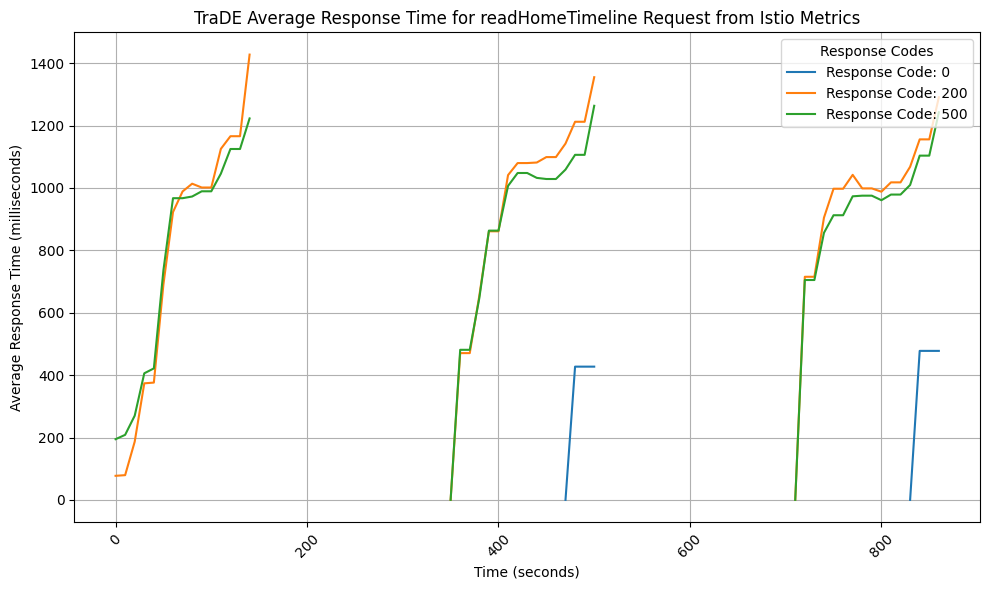

In [4]:
'''(1) plot Response Time for namesapce of social-network3 ''' # TraDE scheduling method

import pandas as pd
import matplotlib.pyplot as plt
import ast

# Load the CSV file
file_path = 'data/prometheus_data_latency_avg3.csv'
df = pd.read_csv(file_path)

# Convert the 'metric' column dictionaries to strings
df['metric'] = df['metric'].apply(lambda x: ast.literal_eval(x))
# Extract the response_code from the 'metric' column
df['response_code'] = df['metric'].apply(lambda x: x.get('response_code', 'unknown'))
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate the elapsed time in seconds from the start of data collection
df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

# Plot the data
if not df.empty:
    plt.figure(figsize=(10, 6))
    
    for key, grp in df.groupby('response_code'):
        plt.plot(grp['elapsed_time'], grp['value'], label=f'Response Code: {key}')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Average Response Time (milliseconds)')
    plt.title('TraDE Average Response Time for readHomeTimeline Request from Istio Metrics')
    plt.grid(True)
    plt.legend(title='Response Codes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


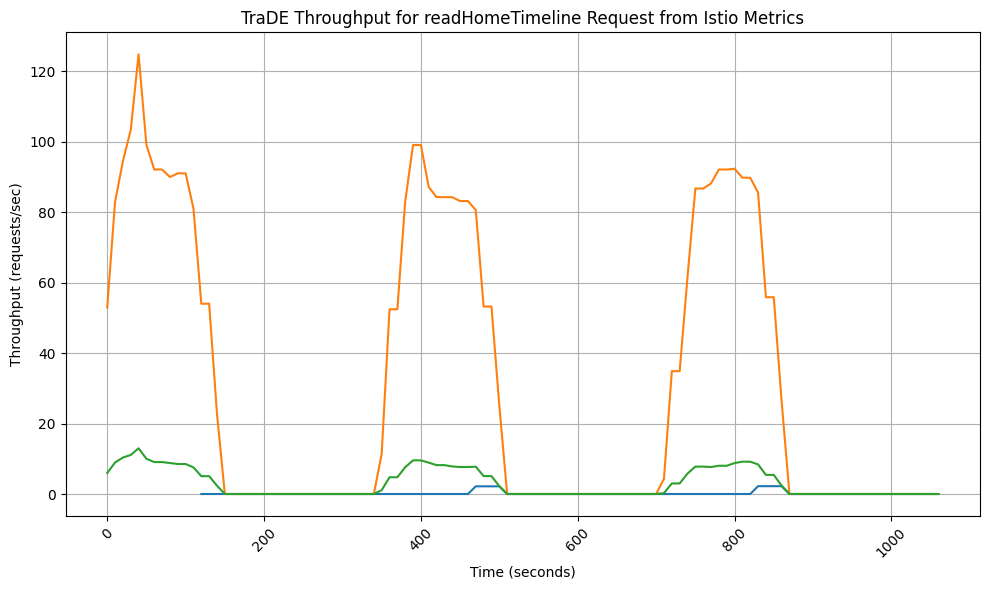

In [20]:
'''(3) plot Throughput for namesapce of social-network3 ''' # TraDE scheduling method
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'data/prometheus_data_througuput3.csv'
df = pd.read_csv(file_path)

# Convert the 'metric' column dictionaries to strings
df['metric'] = df['metric'].apply(lambda x: str(eval(x)))
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Calculate the elapsed time in seconds from the start of data collection
df['elapsed_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

# Plot the data
if not df.empty:
    plt.figure(figsize=(10, 6))
    
    for key, grp in df.groupby(['metric']):
        plt.plot(grp['elapsed_time'], grp['value'], label=key)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Throughput (requests/sec)')
    plt.title('TraDE Throughput for readHomeTimeline Request from Istio Metrics')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.savefig('prometheus_data_plot.png')  # Save plot as a PNG file
    plt.show()  # Display the plot

# print("Plot has been saved to prometheus_data_plot.png")